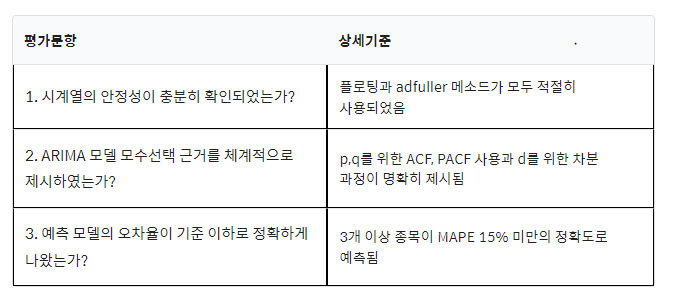

오늘은 ARIMA를 통해 시계열 데이터를 에측하는 과정을 진행해보았습니다. 
주제는 한국전력에 대한 주식 시세 예측입니다. 2016-2019로 총 4년치의 데이터를 학습시켜보았습니다.







In [1]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

import math
import warnings
warnings.filterwarnings('ignore') #경고 무시

import os
import glob
from matplotlib.pylab import rcParams

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# STEP 1 : 시계열 데이터 준비
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
- 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

## 한국전력 2016-2019 4년치

In [2]:
dataset_filepath = glob.glob('{}/aiffel/stock_prediction/data/*kor*.csv'.format(os.getenv('HOME')))
print(dataset_filepath)
df = pd.read_csv(dataset_filepath[0], index_col='date', parse_dates=True)

rcParams['figure.figsize'] = 13, 6  # matlab 차트의 기본 크기를 13, 6로 지정해 줍니다.


# del ts
ts = df['close']

print()
print(type(ts))

ts.head()



['/aiffel/aiffel/stock_prediction/data/015760_korElec.csv']

<class 'pandas.core.series.Series'>


date
2016-01-04    50000.0
2016-01-05    50700.0
2016-01-06    50800.0
2016-01-07    50300.0
2016-01-08    49900.0
Name: close, dtype: float64

# step 2 : 각종 전처리 수행

- 결측치 처리
- 로그 변환

## 결측치 처리

In [3]:
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: close, dtype: float64)

## 로그변환

In [4]:
ts_log = np.log(ts)

# STEP 3 : 시계열 안정성 분석

- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인



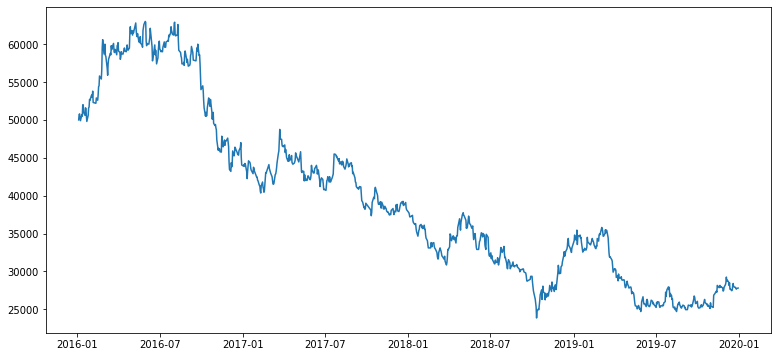

In [5]:
ts = df['close']
plt.plot(ts)

## 정성적 그래프 분석

In [6]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


In [7]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

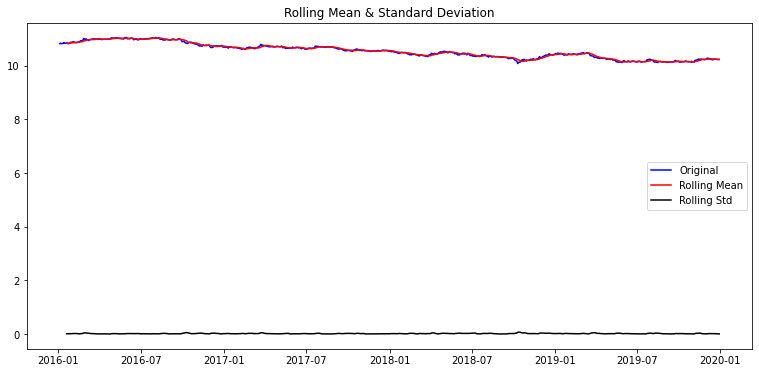

Results of Dickey-Fuller Test:
Test Statistic                  -0.804220
p-value                          0.817879
#Lags Used                       0.000000
Number of Observations Used    978.000000
Critical Value (1%)             -3.437054
Critical Value (5%)             -2.864500
Critical Value (10%)            -2.568346
dtype: float64


In [8]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 


# 결론 !¶
p-value의 값 0.817879이므로, 0.05보다 매우 큰 값입니다. 분명히 귀무가설을 기각할 이유가 없습니다. 따라서 시계열은 실제로 비정상적입니다.

In [9]:

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

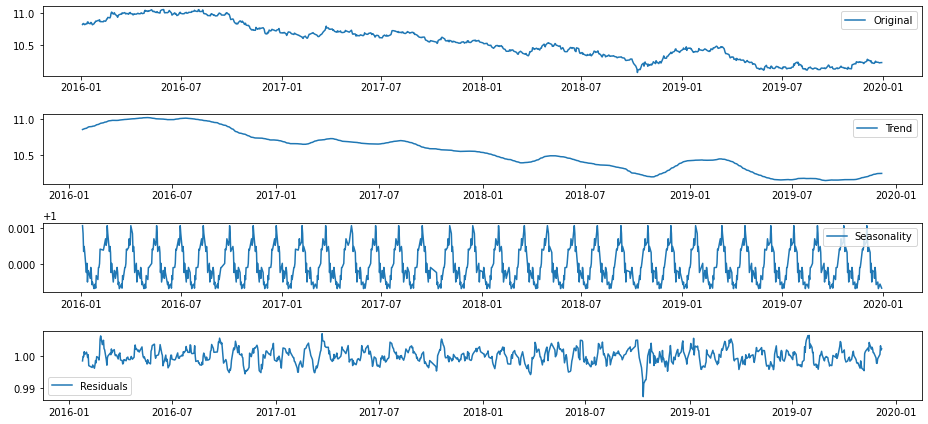

In [10]:
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

## residual 안정성 확인

In [11]:
# 예시코드

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.224610e+01
p-value                        9.775949e-23
#Lags Used                     9.000000e+00
Number of Observations Used    9.390000e+02
Critical Value (1%)           -3.437333e+00
Critical Value (5%)           -2.864623e+00
Critical Value (10%)          -2.568412e+00
dtype: float64


# 결론 !¶
p-value의 값 9.775949e-23 = 0으로, 0.05보다 매우작은값입니다. 즉 p-value의 값이 유의 수준 0.05보다 매우 작으므로 귀무 가설을 기각하고 계열이 정상적이라고 간주할 수 있습니다.

# 로그변환 만으론 부족, Moving average 제거

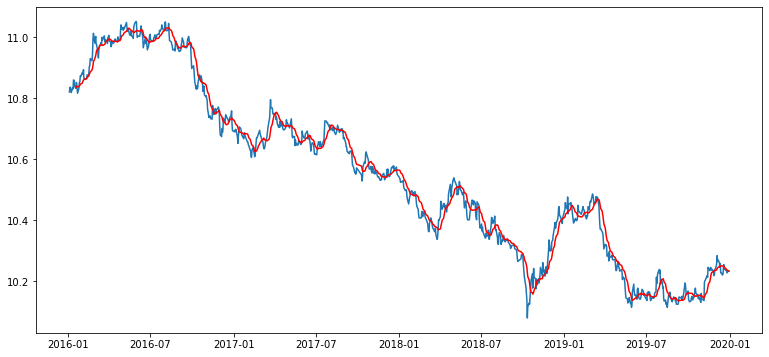

In [12]:
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [13]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

date
2016-01-04         NaN
2016-01-05         NaN
2016-01-06         NaN
2016-01-07         NaN
2016-01-08         NaN
2016-01-11         NaN
2016-01-12         NaN
2016-01-13         NaN
2016-01-14         NaN
2016-01-15         NaN
2016-01-18         NaN
2016-01-19    0.014892
2016-01-20    0.010489
2016-01-21   -0.008790
2016-01-22   -0.021092
Name: close, dtype: float64

In [14]:
# 결측치 제거

ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

date
2016-01-19    0.014892
2016-01-20    0.010489
2016-01-21   -0.008790
2016-01-22   -0.021092
2016-01-25   -0.005651
2016-01-26    0.011128
2016-01-27    0.011436
2016-01-28    0.027040
2016-01-29    0.024185
2016-02-01    0.033626
2016-02-02    0.031828
2016-02-03    0.022322
2016-02-04    0.033824
2016-02-05    0.004262
2016-02-11   -0.000411
Name: close, dtype: float64

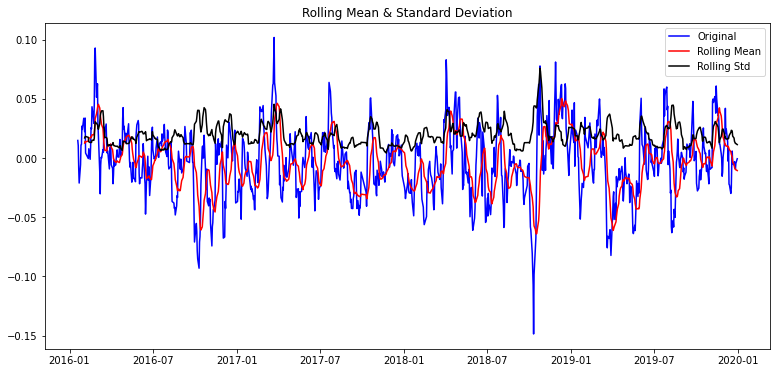

In [15]:
plot_rolling_statistics(ts_log_moving_avg)

In [16]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                -6.055857e+00
p-value                        1.245698e-07
#Lags Used                     1.200000e+01
Number of Observations Used    9.550000e+02
Critical Value (1%)           -3.437216e+00
Critical Value (5%)           -2.864571e+00
Critical Value (10%)          -2.568384e+00
dtype: float64


p-value의 값이 1.245698e-07 = 0.0000001245698로 유의미하게 작아졌습니다. 이제 시계열 값으로 사용이 가능할듯합니다!

# STEP 4 : 학습, 테스트 데이터셋 생성

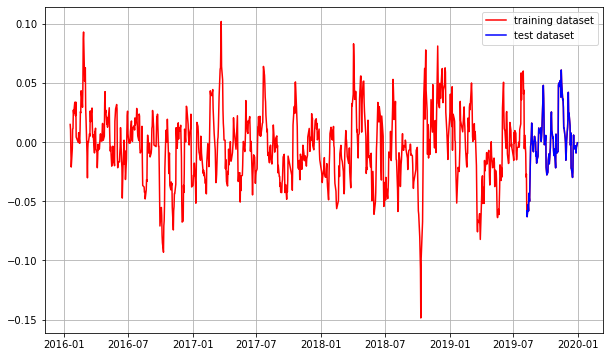

In [17]:
train_data, test_data = ts_log_moving_avg[:int(len(ts_log_moving_avg)*0.9)], ts_log_moving_avg[int(len(ts_log_moving_avg)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log_moving_avg, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log_moving_avg를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# STEP 5 : 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

## ACF, PACF 그려보기 - p, q 구하기

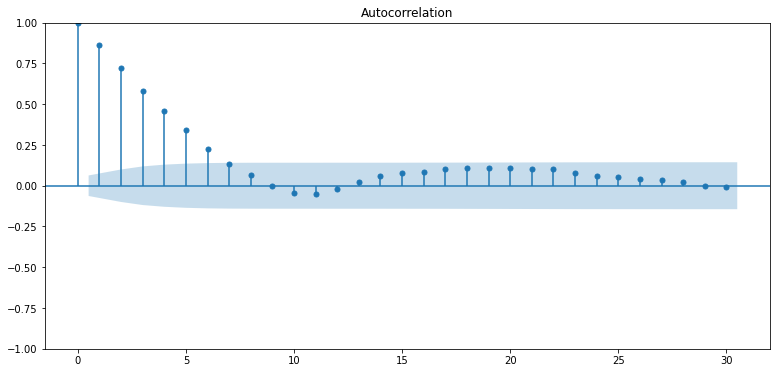

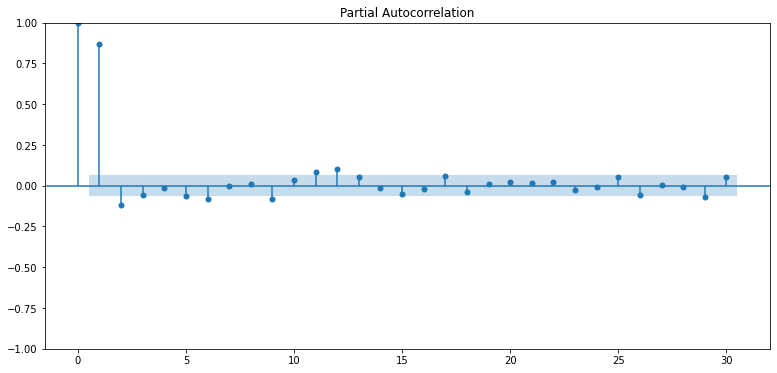

In [18]:
plot_acf(ts_log_moving_avg)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log_moving_avg)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

## 차분 안정성 확인 - d 구하기

Results of Dickey-Fuller Test:
Test Statistic                 -30.161664
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    977.000000
Critical Value (1%)             -3.437061
Critical Value (5%)             -2.864503
Critical Value (10%)            -2.568348
dtype: float64


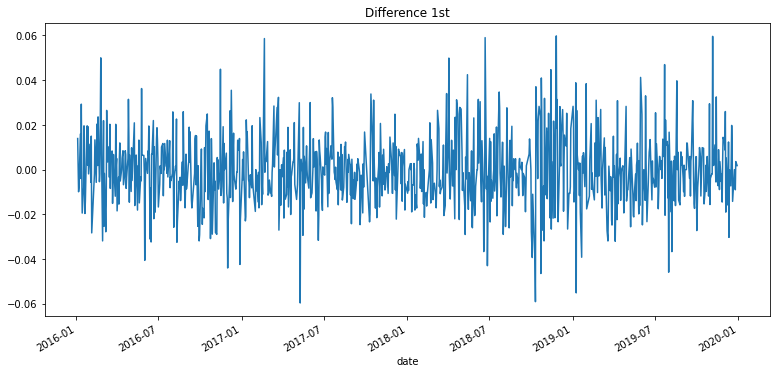

In [19]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)


Results of Dickey-Fuller Test:
Test Statistic                -1.217723e+01
p-value                        1.377337e-22
#Lags Used                     2.100000e+01
Number of Observations Used    9.550000e+02
Critical Value (1%)           -3.437216e+00
Critical Value (5%)           -2.864571e+00
Critical Value (10%)          -2.568384e+00
dtype: float64


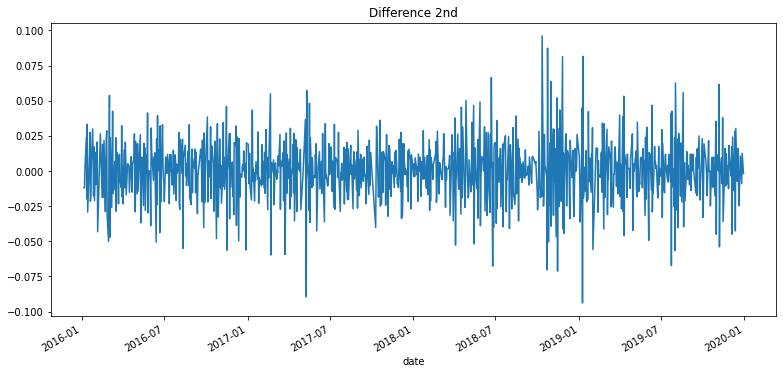

In [20]:

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# STEP 6 : ARIMA 모델 훈련과 테스트 1

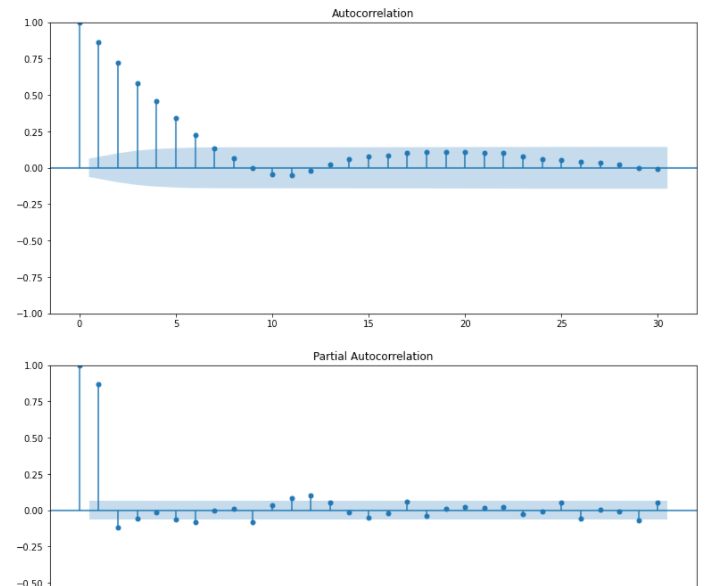


## (p, d, q) = 1, 0, 0

네이버와 현대차와 마찬가지로, p=1 이후에 PACF에서 AR값이 0이되므로 주고, q는 p + q < 2, p * q = 0에 맞춰주기 위해 0으로 주었습니다.

d값은 1차 미분이나 2차미분이나 0의 안정화를 보였기 때문에 d=0을 시도해보았습니다.

In [21]:
# Build Model
model = ARIMA(train_data, order=(1, 0, 0))  # 1.65
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  871
Model:                 ARIMA(1, 0, 0)   Log Likelihood                2425.300
Date:                Wed, 16 Feb 2022   AIC                          -4844.600
Time:                        08:52:19   BIC                          -4830.291
Sample:                             0   HQIC                         -4839.125
                                - 871                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0040      0.004     -1.052      0.293      -0.012       0.003
ar.L1          0.8666      0.014     62.119      0.000       0.839       0.894
sigma2         0.0002   8.87e-06     25.136      0.0

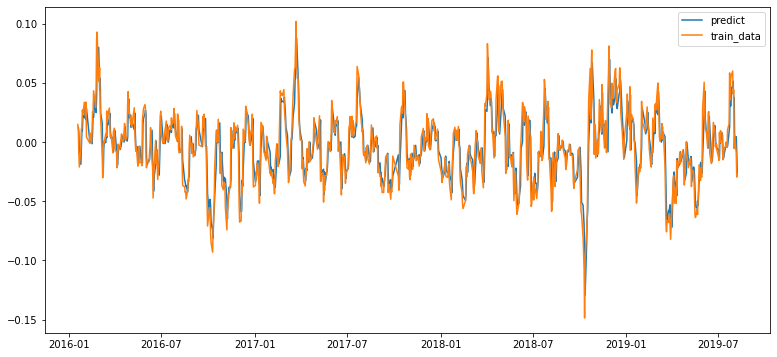

In [22]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

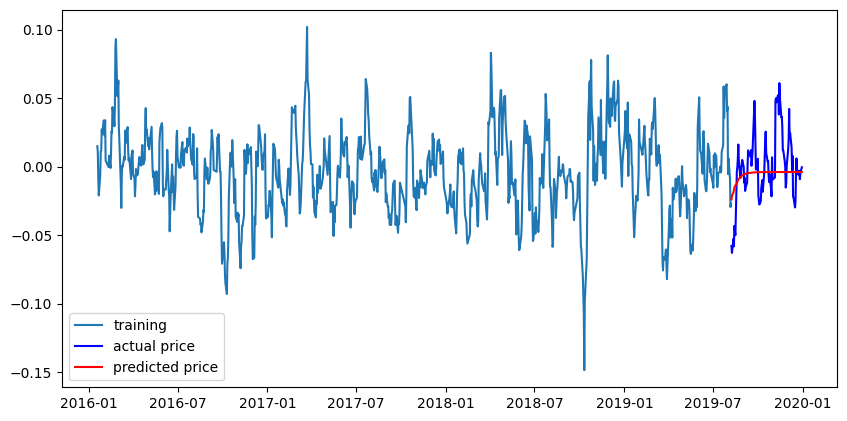

In [23]:
model = ARIMA(train_data, order=(1, 0, 0))
fitted_m = model.fit() 
# Forecast : 결과가 fc에 담깁니다. 

fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [24]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  0.0005969787868880918
MAE:  0.01819981588300672
RMSE:  0.024433149344447836
MAPE: 1.80%


# 테스트 1 분석

MAPE는 1.76으로 나쁘진 않지만, 앞선 퍼센트 들에 비해선 큰것같아서 d=1로 주어 다시 시도해보려합니다.


# STEP 6 : ARIMA 모델 훈련과 테스트 2

## (p, d, q) = 1, 1, 0



In [25]:
# Build Model
model = ARIMA(train_data, order=(1, 1, 0)) 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  871
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2393.943
Date:                Wed, 16 Feb 2022   AIC                          -4783.885
Time:                        08:52:19   BIC                          -4774.348
Sample:                             0   HQIC                         -4780.236
                                - 871                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0486      0.030      1.631      0.103      -0.010       0.107
sigma2         0.0002   9.48e-06     25.162      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-

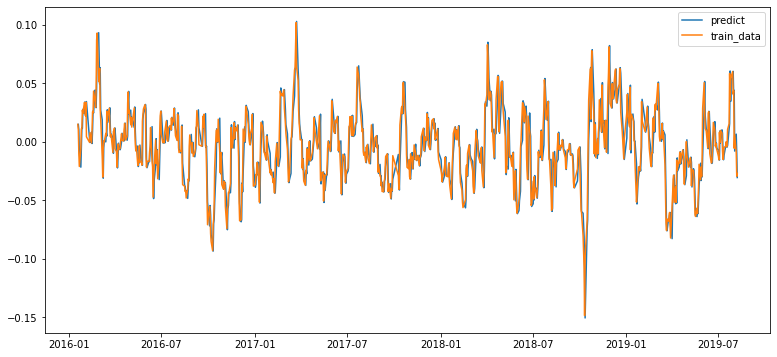

In [26]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

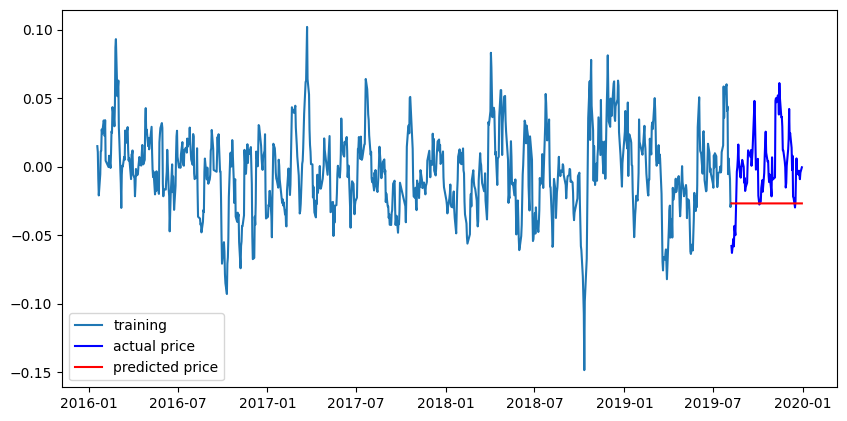

In [27]:
model = ARIMA(train_data, order=(1, 1, 0))  # 1.65
fitted_m = model.fit() 
# Forecast : 결과가 fc에 담깁니다. 

fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [28]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  0.0014496931991375306
MAE:  0.032053937618665214
RMSE:  0.03807483682351811
MAPE: 3.16%


# 테스트 2 결과 분석

d = 1의 값을 줬더니 너무 커져서 당황스럽습니다. 생각해보니 네이버에서도 처음 시도할때 d 미분값이 둘 다 0에 가까울때 d = 1을줬더니 오히려 오차가 커졌었습니다. 그래서 이번엔 q의 값을 변경해보려합니다.

# STEP 6 : ARIMA 모델 훈련과 테스트 3

테스트 1에서는 AR(p)의 값을 중점적으로 신경썼으므로, 이번에는 MA(q)의 값을 신경써보았습니다. 

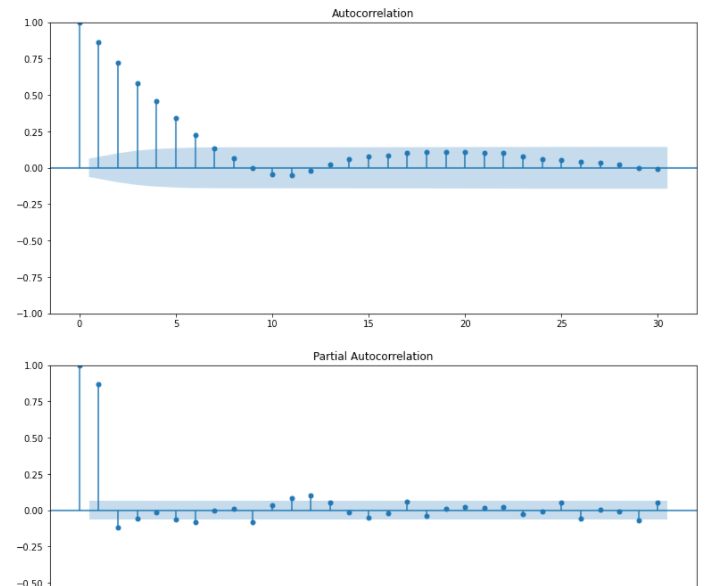

## (p, d, q) = 0, 0, 8



In [29]:
# Build Model
model = ARIMA(train_data, order=(0, 0, 8)) 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  871
Model:                 ARIMA(0, 0, 8)   Log Likelihood                2434.828
Date:                Wed, 16 Feb 2022   AIC                          -4849.656
Time:                        08:52:26   BIC                          -4801.960
Sample:                             0   HQIC                         -4831.407
                                - 871                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0040      0.003     -1.577      0.115      -0.009       0.001
ma.L1          0.9567      0.029     32.990      0.000       0.900       1.014
ma.L2          0.8313      0.043     19.533      0.0

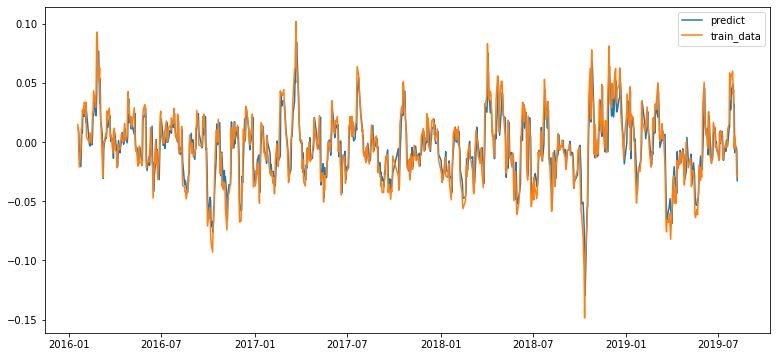

In [30]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

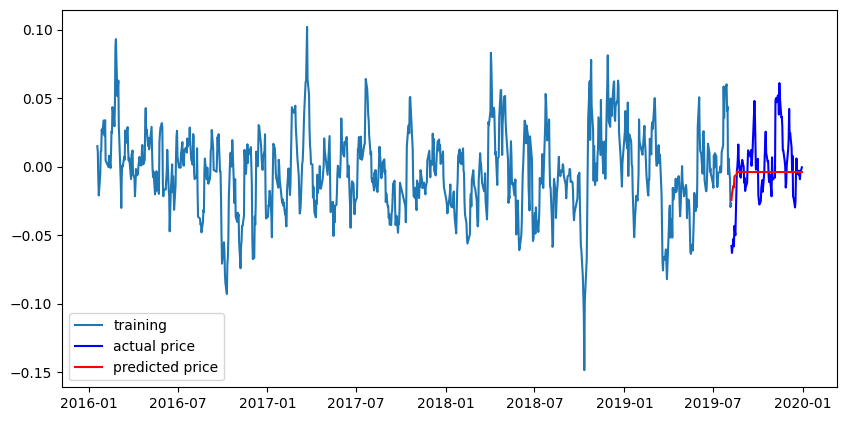

In [31]:
model = ARIMA(train_data, order=(0,0,8))
fitted_m = model.fit() 
# Forecast : 결과가 fc에 담깁니다. 

fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [32]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  0.0006046945415461991
MAE:  0.01808551486793697
RMSE:  0.024590537642479454
MAPE: 1.79%


# 테스트 3 결과 분석

눈콥만큼 작아졌습니다. 하지만 이번 결과에서는 p, q의 값은 p + q < 2, p * q = 0라고 잘나오는 것 같진 않았습니다. 그래서 q의 값을 고정해두고 p를 올려보았습니다.

# STEP 6 : ARIMA 모델 훈련과 테스트 4



## (p, d, q) = 1, 0, 8



In [33]:
# Build Model
model = ARIMA(train_data, order=(1, 0, 8)) 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  871
Model:                 ARIMA(1, 0, 8)   Log Likelihood                2443.344
Date:                Wed, 16 Feb 2022   AIC                          -4864.687
Time:                        08:52:39   BIC                          -4812.221
Sample:                             0   HQIC                         -4844.613
                                - 871                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0040      0.003     -1.243      0.214      -0.010       0.002
ar.L1          0.5947      0.101      5.882      0.000       0.397       0.793
ma.L1          0.3585      0.104      3.433      0.0

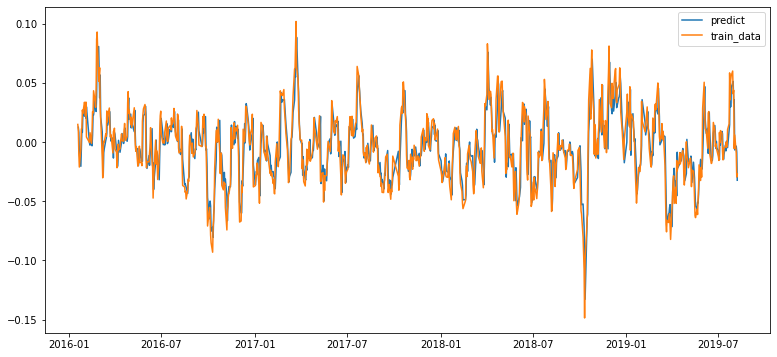

In [34]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

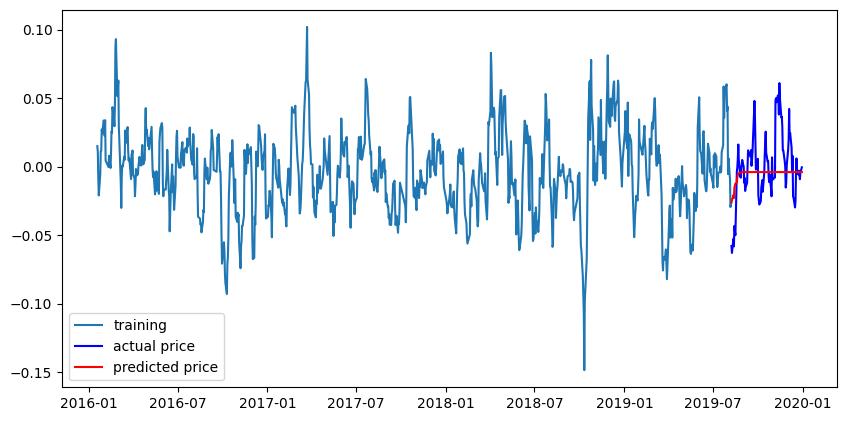

In [35]:
model = ARIMA(train_data, order=(1, 0 , 8))
fitted_m = model.fit() 
# Forecast : 결과가 fc에 담깁니다. 

fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [36]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  0.0005822385795508454
MAE:  0.01788433728946267
RMSE:  0.024129620377263405
MAPE: 1.77%


## 정리

p, q의 값은 p + q < 2, p * q = 0인 값을 많이 쓴다는데, 이렇게 주는게 보편적으로 값이 잘 나오지만, 꼭 그런것 만은 아닌것같다. 저 값을 주로 쓴다는 것을 알아만 두고 경우에따라 저 범위를 벗어난 것도 시도해보는게 좋을 것같다.

# 기억하고 싶은 것

- warning 뜨는 것 무시
아래 코드를 사용하면 warning이 뜨는것을 무시할 수 있다.

In [37]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

# 추후에 더 하고싶은 것

1. 여기선 close 종가만을 가지고 예측을 했는데, 같은 타임 step에서의 거래량이나 pbr, per을 가진 dataframe을 이용해서 모수를 찾고 모델을 학습시켜보고싶습니다.

2. 시계열이야 말로 gridsearch 기술이 가장 적합하게 사용될 분야라고 생각이 든다. 
p, d, q의 값의 범위를 한정해두고 그 사이값을 하나씩 변경하면서 시도해보면 best값을 찾을 수 있을 것 같다. sklearn이 적용이 어렵다면, 그냥 중첩 for문으로 p, d, q의 값을 넣어서 계산하는 함수를 사용해보고싶다.